In [1]:
## Load python modules
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap

In [2]:
adata = sc.read("../../data/EpiHiRes.h5ad", cache = True)

### Figure 4 b

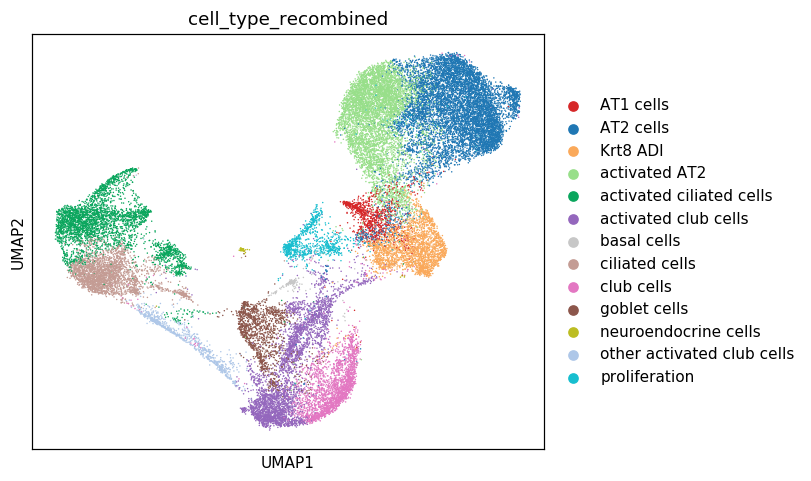

In [3]:
type_palette = ["#d62728", '#1f77b4', '#faa95a', '#98df8a', "#0aa65d", '#9467bd', '#c7c7c7', 
                '#c49c94', '#e377c2', '#8c564b', '#bcbd22', '#aec7e8', '#17becf']
sc.pl.umap(adata, color = "cell_type_recombined", ax = plt.figure(figsize = (6, 5), dpi = 110).gca(),
           palette = type_palette)

### Figure 4 c

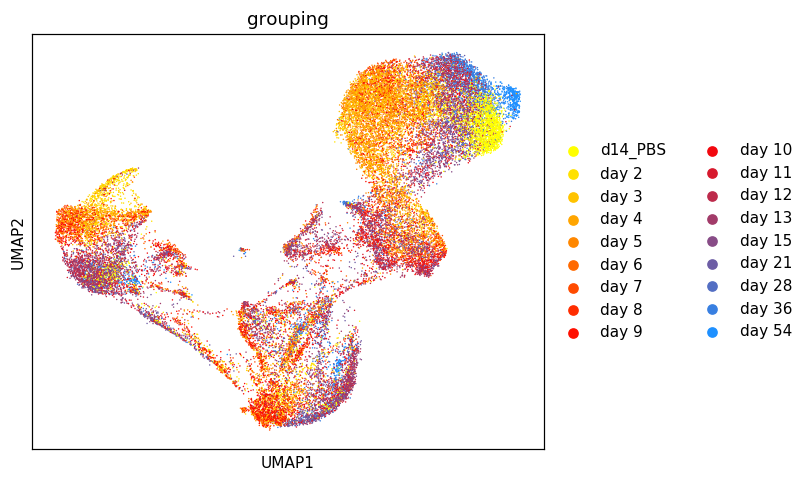

In [5]:
sc.pl.umap(adata, color = "grouping", ax = plt.figure(figsize = (6, 5), dpi = 110).gca())

### Figure 4 d

In [6]:
## New adapted Version (from V1)
def calc_relFreq(a, group_by = "cell_type", xlabel = "days", condition = "batch"):
    freqs = a.obs.groupby(["identifier", group_by]).size()
    samples = np.unique(a.obs["identifier"])
    ind = a.obs[group_by].cat.categories
    
    relFreqs = [freqs[ident] / sum(freqs[ident]) for ident in samples]
    relFreqs = pd.DataFrame(relFreqs, columns = ind, index = samples).fillna(0)

    #relFreqs[xlabel] = grouping.loc[samples, xlabel]  ## when using Grouping Table
    cell_types = {}
    combis = a.obs.groupby(["identifier", xlabel]).groups.keys()

    for c in combis:
        cell_types[c[0]] = c[1]
    relFreqs[xlabel] = [cell_types[l] for l in relFreqs.index]

    ## Todo, add for condition
    if condition:
        combis = adata.obs.groupby(["identifier", condition]).groups.keys()
        for c in combis:
            cell_types[c[0]] = c[1]
        relFreqs[condition] = [cell_types[l] for l in relFreqs.index]
    
    return relFreqs

In [7]:
## Exclude 28, as too few cells could be collected
adata28 = adata[-adata.obs["grouping"].isin(["day 28"])].copy()

## Combine last 3 timepoints into one category
order = ['d14_PBS', 'day 2', 'day 3', 'day 4', 'day 5', 'day 6', 'day 7', 'day 8', 
         'day 9', 'day 10', 'day 11', 'day 12', 'day 13', 'day 15', 'day 21 - 54']
adata28.obs["days"] = [14 if i in ["day 21", "day 36", "day 54"] else list(order).index(i)
                       for i in adata28.obs["grouping"]]

group_by = "cell_type_recombined"
xlabel = "days"

relFreqs = calc_relFreq(adata28, group_by = group_by, xlabel = xlabel, condition = None)

KeyboardInterrupt: 

In [ ]:
## Subset to cell types of interest
types = ["AT1 cells", "AT2 cells", "Krt8 ADI", "club cells", "activated club cells", "activated AT2"]
sub_freqs = relFreqs.loc[:, types + [xlabel]]
for t in types:
    sub_freqs[t] = np.interp(sub_freqs[t], (sub_freqs[t].min(), sub_freqs[t].max()), (0, +1))

sub_freqs = pd.melt(sub_freqs, id_vars = "days", var_name = "typ")
cat = sb.lmplot(data = sub_freqs, x = xlabel, y = "value", ci = 25, order = 4, scatter = None, legend= False,
                   hue = "typ", truncate = True)

plt.legend(loc = 9, ncol = 6, prop={'size': 20})
cat.set(xticks = np.unique(sub_freqs.loc[:, xlabel]))    
cat.set_xticklabels([o.replace("day ", "") for o in order])

cat.ax.set_xlabel(xlabel, size = 20)
cat.ax.set_ylabel("relative frequency (scaled)", size = 20)
cat.ax.tick_params(labelsize = 20)
cat.fig.set_size_inches((25, 10))
#cat.fig.savefig(folder + "Epithel_act_types_relFreq_scaled.pdf")

plt.show()
plt.close()

### Fig 4 e

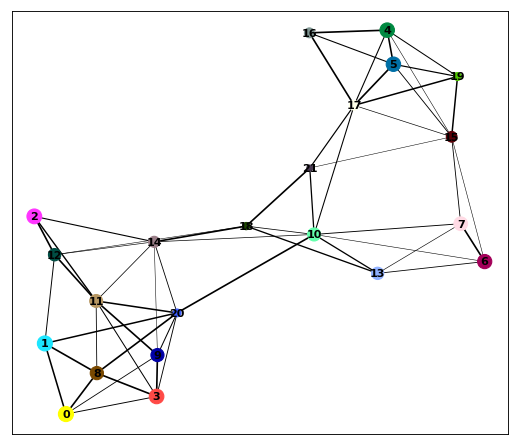

In [8]:
## recalculate PAGA
sc.tl.paga(adata, groups = "louvain")
sc.pl.paga(adata, threshold=0.3, edge_width_scale=.2, ax = plt.figure(figsize = (8,7), dpi = 80).gca()) 

### Fig 4 h

In [19]:
## Overlay gene signature on UMAP using Scanpy Scoring
from matplotlib import colors
colorsComb = np.vstack([plt.cm.Reds(np.linspace(0, 1, 128)), plt.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

folder = "/home/agando/Documents/Meshal/PhD_Scripts/short_scripts/Bleo_highRes/Epithel/"
gene_list = pd.read_csv(folder + "Data/Broad_hallmark_gene_sets_2.txt", sep = "\t")

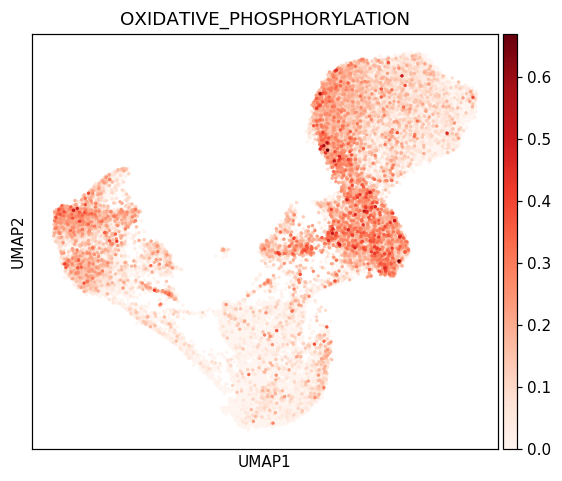

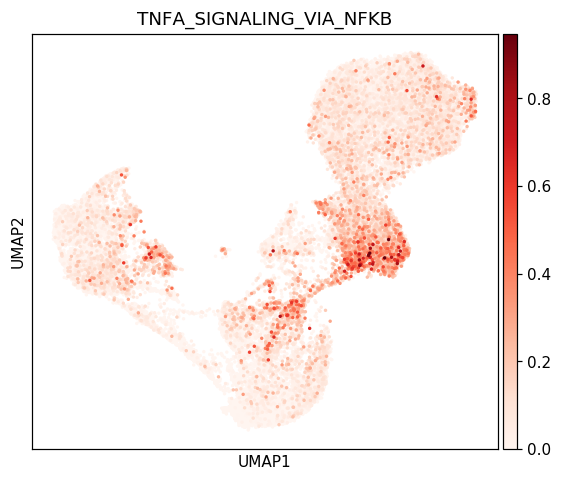

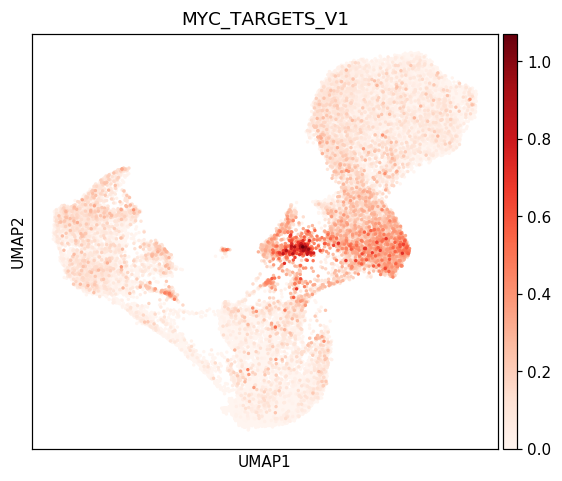

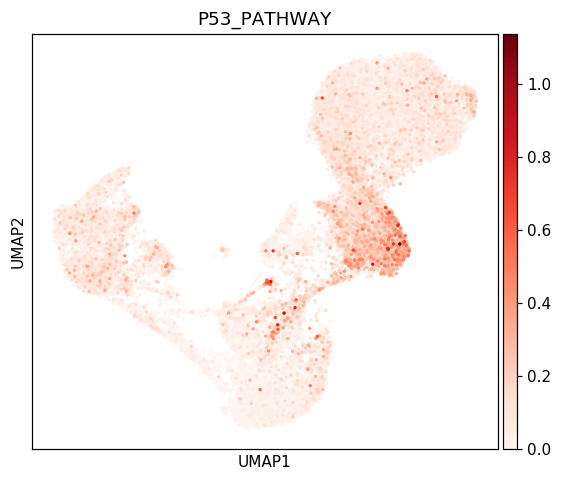

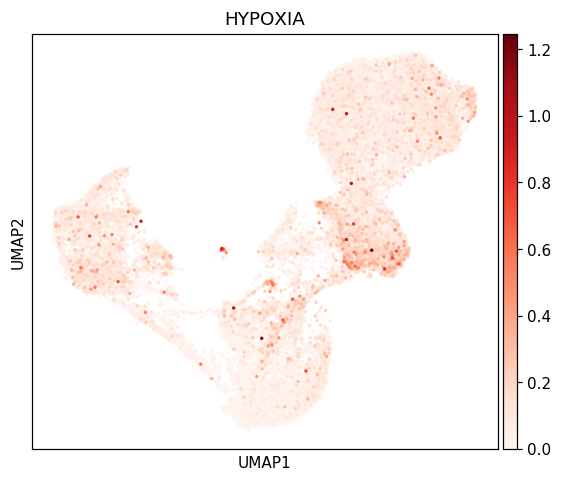

In [25]:
pathways = ["HALLMARK_OXIDATIVE_PHOSPHORYLATION", "HALLMARK_TNFA_SIGNALING_VIA_NFKB",
            "HALLMARK_MYC_TARGETS_V1", "HALLMARK_P53_PATHWAY", "HALLMARK_HYPOXIA"]
for pathway in pathways:
    genes = gene_list.loc[:, pathway].values
    genes = [g.capitalize() for g in genes]
    genes = np.intersect1d(genes, adata.var_names)
    s_name = pathway.replace("HALLMARK_", "")
    sc.tl.score_genes(adata, gene_list = genes, score_name = s_name)
    sc.pl.umap(adata, color = s_name, ax = plt.figure(figsize = (6, 5), dpi = 110).gca(),
              legend_loc = "on data", cmap = mymap, vmin = 0, size = 20)